# Petermann Heat Transport

Use icepack HeatTransport model to obtain a Petermann system in thermal equilibrium from RACMO2 surface temp and Martos geothermal flux data

## Setup

In [1]:
import sys 
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import xarray as xr
import rasterio

import geojson

import firedrake
import icepack
import icepack.plot

/mnt/data01/Code/OtherRepos/firedrake/lib/python3.8/site-packages/pytools/__init__.py:2408: UserWarning: unable to find git revision
  warn("unable to find git revision")
fatal: detected dubious ownership in repository at '/mnt/data01/Code/OtherRepos/firedrake/src/PyOP2'
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/data01/Code/OtherRepos/firedrake/src/PyOP2
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


### Mesh

In [4]:
outline_fn = 'petermann_streamlines_evenspace_full.geojson'
fn=outline_fn.split('.')[0]

with open(outline_fn, 'r') as outline_file:
    outline = geojson.load(outline_file)

In [ ]:
if os.path.isfile(fn+'.msh'):
    pass
else:
    geometry = icepack.meshing.collection_to_geo(outline)

    with open('petermann_streamline_evenspace_full.geo', 'w') as geo_file:
        geo_file.write(geometry.get_code())
        
    !gmsh -2 -format msh2 -v 2 -o petermann_streamline_evenspace_full.msh petermann_streamline_evenspace_full.geo;

In [3]:
mesh2d = firedrake.Mesh('petermann_streamlines_evenspace'+'.msh')
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

new_fn_nc = '../Petermann-xzflowline/Models/Petermann-centerline.nc'
flowline = xr.open_dataset(new_fn_nc)
line = np.stack([flowline['x_pol'][0].values,flowline['y_pol'][0].values]).T

### Load/Interpolate Raster Data

#### Reading Data
Here, you should define root_ddir as the directory containing the BedMachine, MEaSUREs, hillshade, and climate forcing files
All files except BedMachine can be found [here](https://drive.google.com/drive/folders/1vSetbOF5Iy26ETMAF_-VXlrqotyp_3EO?usp=sharing).
BedMachine and other file sources can be found here:
- [BedMachine](https://nsidc.org/data/idbmg4/versions/5)
- [MEaSUREs](https://nsidc.org/grimp)
- [Martos Geothermal heat flux](https://doi.pangaea.de/10.1594/PANGAEA.892973?format=html#download)
- [RACMO2 Surface Temperature/Surface Mass Balance](https://doi.org/10.5194/tc-10-2361-2016) (Need to email author Brice Noel for dataset)
- [Hillshade](https://drive.google.com/drive/folders/1vSetbOF5Iy26ETMAF_-VXlrqotyp_3EO?usp=sharing) (creator is Nicholas Holchuh)


In [10]:
### Reading Data
### Here, you should define root_ddir as the directory containing the BedMachine, MEaSUREs, hillshade, and climate forcing files

root_ddir = '/mnt/data01/Data/'

velocity_fn = glob.glob(root_ddir+'*vel*.nc')
ice_info_fn = glob.glob(root_ddir+'*BedMachine*.nc')
hillshade_fn = glob.glob(root_ddir+'*Hillshade*.nc') 
geothermal_fn = glob.glob(root_ddir+'*Martos*.nc')
racmo_fn = glob.glob(root_ddir+'*RACMO*.nc')

### Hillshade
hs = xr.open_dataset(hillshade_fn[0])

### Velocities
vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
vz=vy.copy()
vz.values=np.zeros(np.shape(vy.values))
speed=np.sqrt(vx**2+vy**2)

### Glacial geometry
ice_bed_props = rxr.open_rasterio(ice_info_fn[0])
thickness = ice_bed_props['thickness'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]

### Climate forcings
geothermal = xr.open_rasterio(geothermal_fn[0])[0,:,:]/1000
racmo = xr.open_dataset(racmo_fn[0])
surftemp = racmo['T2m_avg']
SMB = racmo['SMB_avg']

/tmp/ipykernel_266492/2880713045.py:23: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geothermal = xr.open_rasterio(geothermal_fn[0])[0,:,:]/1000


In [5]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='R', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2, vfamily='GL', vdegree=2)

h0 = icepack.interpolate_xr(thickness, Q)
s0 = icepack.interpolate_xr(surface, Q)
b = icepack.interpolate_xr(bed, Q)
u0 = icepack.interpolate_xr((vx, vy), V)
gt0 = icepack.interpolate_xr(geothermal, Q)
st0 = icepack.interpolate_xr(surftemp, Q)

#q = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
#v = firedrake.VectorFunctionSpace(mesh2d, family='CG', degree=2)

#h0_2d = icepack.interpolate_xr(thickness, q)
#gt0_2d = icepack.interpolate_xr(geothermal, q)
#st_2d = icepack.interpolate_xr(surftemp, q)
#u0_2d = icepack.interpolate_xr((vx, vy), v)

### Plotting Functions

In [6]:
def subplots(*args, **kwargs):
    zoom = kwargs.get("zoom",0)
    fig, ax = plt.subplots(figsize=[8,8])
    im1=ax.imshow(hs['hillshade'].values,extent=[hs['x'].values.min(),hs['x'].values.max(),hs['y'].values.min(),hs['y'].values.max()],cmap='Greys_r', vmin=0,vmax=200,origin='upper')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    if zoom == -1:
        ax.set_ylim([-1.6e6,-1e6]);
        ax.set_xlim([-0.325e6,0.1e6]);
    elif zoom == 0:
        ax.set_ylim([-1.55e6,-.9e6]);
        ax.set_xlim([-0.3e6,0.05e6]);
    elif zoom == 1:
        ax.set_ylim(-1.1e6,-0.9e6);
        ax.set_xlim(-3e5,-1.5e5);

    ax.set_aspect('equal')
    
    return fig, ax

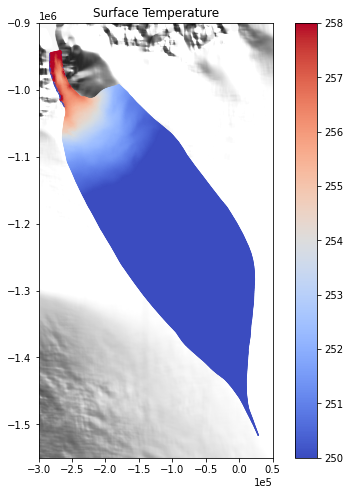

In [7]:
fig,ax=subplots()
colors = firedrake.tripcolor(icepack.depth_average(st0),axes=ax,vmin=250,vmax=258,cmap='coolwarm');
plt.colorbar(colors);
ax.set_title("Surface Temperature");

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:xlabel='Distance Along Glacier (m)', ylabel='Elevation (m)'>)

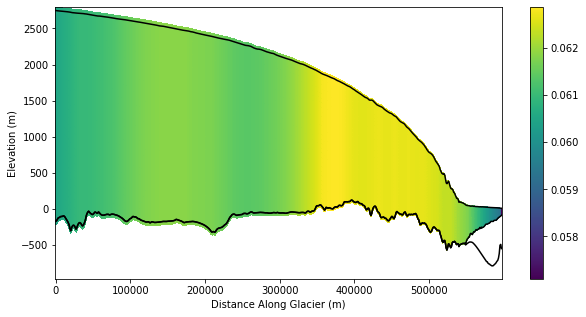

In [18]:
def flowline_search(sl,len_z,var):
    xs=sl.T[0]
    ys=sl.T[1]
    ζs=np.linspace(0.001,0.999,len_z)

    x_coords_grid, ζ_coords_grid = np.meshgrid(xs,ζs)
    y_coords_grid = np.tile(ys,(len(ζs),1))

    orig_size = x_coords_grid.shape
    x_coords_vec = np.reshape(x_coords_grid,[1,np.prod(orig_size)])
    y_coords_vec = np.reshape(y_coords_grid,[1,np.prod(orig_size)])
    ζ_coords_vec = np.reshape(ζ_coords_grid,[1,np.prod(orig_size)])

    coord_list = np.concatenate([x_coords_vec,y_coords_vec,ζ_coords_vec]).T
    
    var_extract = []
    for i in coord_list:
        var_extract.append(var.at(i[0],i[1],i[2]))
            
    var_extract_vec = np.array(var_extract)
    var_extract_grid = np.reshape(var_extract,orig_size)
    
    return(var_extract_grid, x_coords_grid, y_coords_grid, ζ_coords_grid)

def glacier_plot(sl_dist,surf,bed,thick,dist_coords_grid,z_coords_grid,var_coords_grid,**kwargs):
    vmin = kwargs.get("vmin")
    vmax = kwargs.get("vmax")
    cmap = kwargs.get("cmap")
    
    
    fig,ax = plt.subplots(figsize=(10,5))

    cdata = ax.pcolor(dist_coords_grid,z_coords_grid,var_coords_grid,vmin=vmin,vmax=vmax,cmap=cmap)
    cbar = plt.colorbar(cdata)
    ax.plot(sl_dist,surf,c='black')
    ax.plot(sl_dist,bed,c='black')
    ax.plot(sl_dist,surf-thick,c='black')

    ax.set_xlabel('Distance Along Glacier (m)')
    ax.set_ylabel('Elevation (m)')
    return fig, ax

### Make base datasets for Petermann streamline
len_z=30
z_opts=np.linspace(0.001,0.999,len_z)

sl_dist = flowline['linedist'][0].values
dist_coords_grid = np.tile(sl_dist,(len_z,1))

b_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,b)
s_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,s0)
h_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,h0)
gt_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,gt0)
st_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,st0)

surf = s_sl[0,:]
bed = b_sl[0,:]
thick = h_sl[0,:]

z_coords_grid = np.tile(surf,(len_z,1))-np.matmul(np.matrix(z_opts).T,np.matrix(thick))

glacier_plot(sl_dist,surf,bed,thick,dist_coords_grid,z_coords_grid,gt_sl)

## Modeling

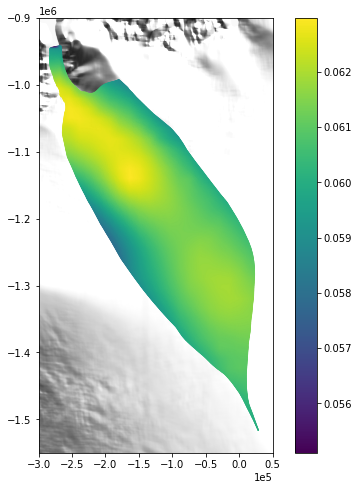

In [7]:
from icepack.constants import (
    ice_density as ρ_I,
    year as year,
    thermal_diffusivity as α,
    heat_capacity as c,
    latent_heat as L,
    melting_temperature as Tm)

### Initial guess of the glacier temperature
ice_t = firedrake.Constant(200)
f = firedrake.Constant(0.)

def energy(T,f):
    return(917 * c * T + 917 * L * f)

E_surf = firedrake.interpolate(energy(st0,f), Q)
E_geo = gt0

fig,ax=subplots()
col=firedrake.tripcolor(icepack.depth_average(E_geo),axes=ax)
plt.colorbar(col)

In [8]:
heat_model = icepack.models.HeatTransport3D()
heat_solver = icepack.solvers.HeatTransportSolver(heat_model)

#Δ = firedrake.FunctionSpace(mesh, family='DG', degree=1)
#E = firedrake.Function(Δ)

In [9]:
import tqdm
final_time = 400.
num_timesteps = 400
dt = final_time / num_timesteps

E_0 = firedrake.interpolate(energy(ice_t,f), Q)
E = E_0.copy(deepcopy=True)

Es=[E_0]

for step in tqdm.trange(num_timesteps):
    E = heat_solver.solve(
        dt=dt,
        energy=E,
        velocity=u0,
        vertical_velocity=firedrake.Constant(0.),
        thickness=h0,
        energy_inflow=firedrake.Constant(0.),
        energy_surface=E_surf,
        heat_bed=gt0,
        heat=firedrake.Constant(0.)
    )
    Es.append(E)
    

  0%|          | 0/400 [00:00<?, ?it/s]


UFLException: Shapes do not match: <Coefficient id=140240690374464> and <ListTensor id=140240690413248>.

## Analysis

In [ ]:
import NDH_Tools as ndh

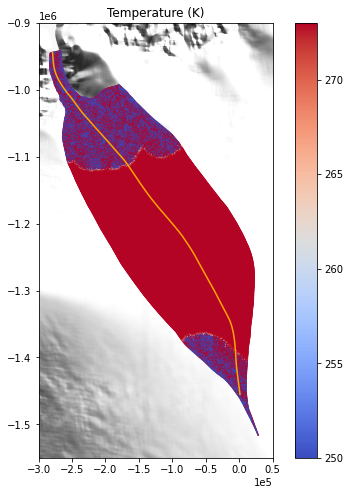

In [16]:
temp=firedrake.interpolate(heat_model.temperature(E),Q)
fig,ax=subplots()
colors = firedrake.tripcolor(icepack.depth_average(temp),axes=ax,cmap='coolwarm',vmin=250,vmax=273);
plt.colorbar(colors);
ax.set_title("Temperature (K)");
ax.plot(flowline['x_pol'][0],flowline['y_pol'][0],'orange');

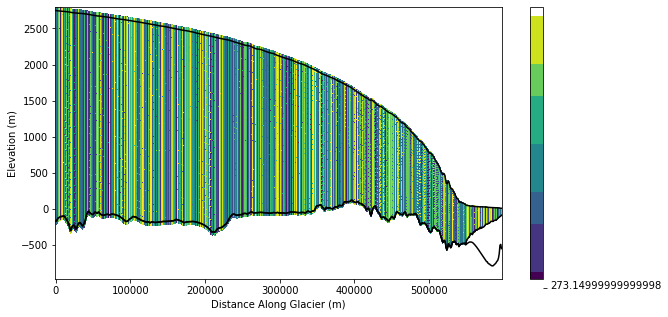

In [20]:
temp=firedrake.interpolate(heat_model.temperature(Es[3]),Q)
temp_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,temp)
fig,ax=glacier_plot(sl_dist,surf,bed,thick,dist_coords_grid,z_coords_grid,temp_sl)

After Generating the Writer, include the following:
Outside the loop:      with writer.saving(fig, videoname, 100):
To capture a frame:    writer.grab_frame()


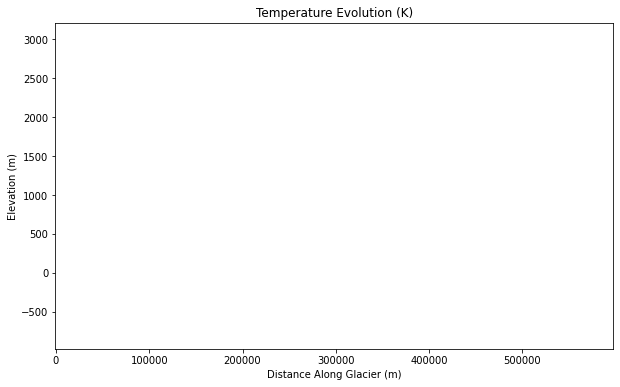

In [47]:
writer = ndh.generate_animation(5,'Slices')
videoname1 = 'Evolution_temp_sl.mp4'

fig, axes = plt.subplots(figsize=(10,6))
axes.set_xlabel('Distance Along Glacier (m)')
axes.set_ylabel('Elevation (m)')
axes.set_title('Temperature Evolution (K)')
with writer.saving(fig, videoname1, 100):
    for i in Es[::20]:
        temp=firedrake.interpolate(heat_model.temperature(i),Q)
        temp_sl, x_coords_grid, y_coords_grid, ζ_coords_grid = flowline_search(line,len_z,temp)
        cdata = axes.pcolor(dist_coords_grid,z_coords_grid,temp_sl,vmin=250,vmax=270,cmap='coolwarm')
        cbar = plt.colorbar(cdata)
        l1=axes.plot(sl_dist,surf,c='black')
        l2=axes.plot(sl_dist,bed,c='black')
        l3=axes.plot(sl_dist,surf-thick,c='black')

        writer.grab_frame()
        
        cbar.remove()
        l1.pop(0).remove()
        l2.pop(0).remove()
        l3.pop(0).remove()
        cdata.remove();

In [48]:
videoname1 = 'Evolution_temp_sl.mp4'
ndh.show_video(videoname1)

After Generating the Writer, include the following:
Outside the loop:      with writer.saving(fig, videoname, 100):
To capture a frame:    writer.grab_frame()


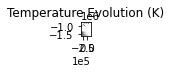

In [46]:
writer = ndh.generate_animation(5,'Slices')
videoname2 = 'Evolution_temp_plane.mp4'

fig, axes = subplots()
axes.set_title('Temperature Evolution (K)')
with writer.saving(fig, videoname, 100):
    for i in Es[::25]:
        temp=firedrake.interpolate(heat_model.temperature(i),Q)
        cdata = firedrake.tripcolor(icepack.depth_average(temp),axes=ax,cmap='coolwarm',vmin=250,vmax=273);
        cbar=plt.colorbar(colors);

        writer.grab_frame()
        
        cbar.remove()
        cdata.remove();

In [47]:
ndh.show_video(videoname2)

In [9]:
import sys
working_dir = '/mnt/data01/User_Scratch/wdienstfrey24/WJD_tools/'
sys.path.append(working_dir)
from MyTools import streamline_coords
from FiredrakeTools import glacier_z_coords, glacier_plot

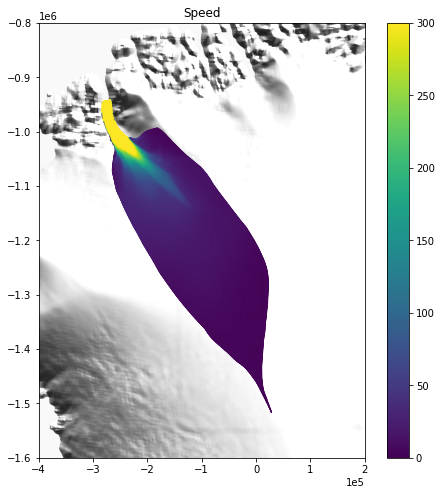

In [10]:
### Pick a seed point
fig,ax=subplots()
colors = firedrake.tripcolor(icepack.depth_average(u0),axes=ax,vmin=0,vmax=300);
plt.colorbar(colors);
ax.set_title("Speed");

<Figure size 432x288 with 0 Axes>

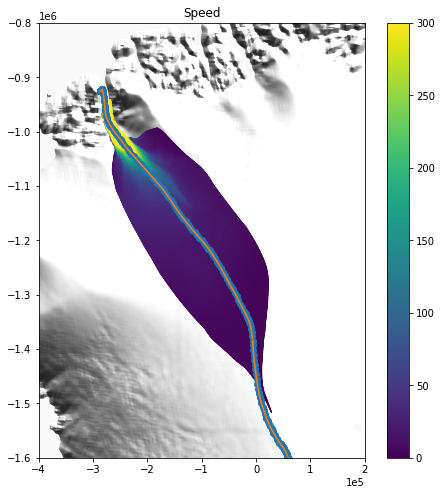

In [11]:
### Use seed point to make streamline and get coordinates with streamline_coords function from WJD_tools
stpt = np.array([-1e5,-1.2e6])
sl = streamline_coords(vx['x'].values,np.flipud(vx['y'].values),np.flipud(vx.values),np.flipud(vy.values),stpt);
sl2 = ndh.calculate_flowlines(vx['x'].values,np.flipud(vx['y'].values),np.flipud(vx.values),np.flipud(vy.values),stpt,max_error=0.1)

fig,ax=subplots()
colors = firedrake.tripcolor(icepack.depth_average(u0),axes=ax,vmin=0,vmax=300);
plt.colorbar(colors);
ax.plot(sl.T[0],sl.T[1],'o')
ax.plot(sl2[0][:,0],sl2[0][:,1])
ax.set_title("Speed");

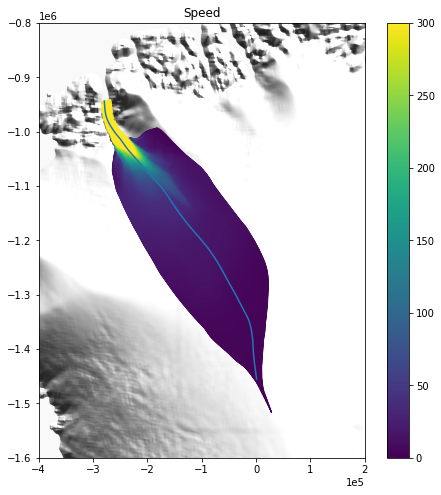

In [12]:
fig,ax=subplots()

start=16353
stop=16468

colors = firedrake.tripcolor(icepack.depth_average(u0),axes=ax,vmin=0,vmax=300);
plt.colorbar(colors);
#ax.plot(sl.T[0],sl.T[1],'o')
ax.plot(sl2[0][:,0][start:stop],sl2[0][:,1][start:stop])
ax.set_title("Speed");

Text(0.5, 1.0, 'Flowline Subselection')

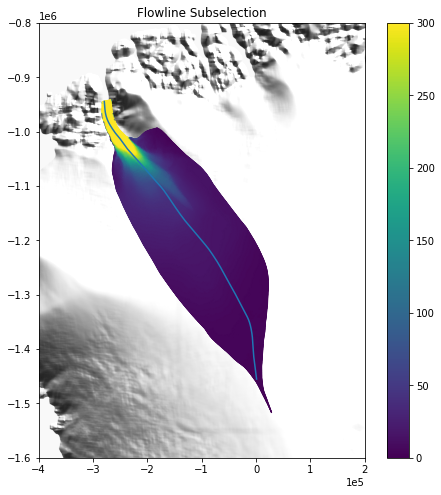

In [13]:
search_ln = sl2[0][start:stop]

### Remove duplicates and fill in line
xs=[]
sl_sub=[]
for i in search_ln:
    if i[0] not in xs:
        sl_sub.append(i)
        xs.append(i[0])
        
sl_sub=ndh.line_fill(np.array(sl_sub).T,1000,1).T

fig,ax=subplots()

colors = firedrake.tripcolor(icepack.depth_average(u0),axes=ax,vmin=0,vmax=300);
plt.colorbar(colors);
#ax.plot(sl.T[0],sl.T[1],'o')
ax.plot(sl_sub.T[0],sl_sub.T[1])
ax.set_title("Flowline Subselection")